In [1]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import math
import tensorflow_addons as tfa

In [20]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

train_ds, validation_ds, test_ds = tfds.load('deep_weeds', as_supervised= True, shuffle_files= True, split=["train[:70%]", "train[70%:90%]", "train[90%:100%]"])

#Pre-Processing
def one_hot(img, label):
    if label == 0:
        ret = tf.ones_like(label)
        return (img, ret)
    else:
        ret = tf.zeros_like(label)
        return (img, ret)

def add_grey_grad(img ,label):
    org_img = img
    img = tf.cast(img, float)
    img = tf.expand_dims(img, axis = 0)
    gray = tf.image.rgb_to_grayscale(img)
    dy , dx = tf.image.image_gradients(gray)
    dmag = tf.math.sqrt(tf.add(tf.math.square(dy),tf.math.square(dx)))

    #Normalize to 0 - 255
    im_max = tf.math.reduce_max(dmag)
    im_min = tf.math.reduce_min(dmag)
    out = (tf.math.subtract(dmag, im_min) / (im_max - im_min)) * 255
    out = tf.expand_dims(tf.cast(out, tf.uint8), axis = 0)
    out = tfa.image.gaussian_filter2d(out[0])
    
    gray = tf.expand_dims(tf.cast(gray, tf.uint8), axis = 0)
    org_img = tf.concat([org_img,gray[0][0],out[0]],-1)
    return (org_img, label)

train_ds = train_ds.map(one_hot)
validation_ds = validation_ds.map(one_hot)
test_ds = test_ds.map(one_hot)

train_ds = train_ds.map(add_grey_grad)
validation_ds = validation_ds.map(add_grey_grad)
test_ds = test_ds.map(add_grey_grad)


train_ds = train_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).batch(BATCH_SIZE).cache()
validation_ds = validation_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).batch(BATCH_SIZE).cache()
test_ds = test_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).batch(BATCH_SIZE).cache()

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 96
Number of validation samples: 28
Number of test samples: 14


In [3]:
from tensorflow.keras import datasets, layers, models, regularizers, Input
import datetime

In [4]:
inputs = Input(shape = (256,256,5), name = "Original_Image")
flip = layers.RandomFlip("horizontal_and_vertical")(inputs)
rotate = layers.RandomRotation((-0.5,0.5), fill_mode = "nearest")(flip)
rescale = layers.Rescaling(1/255)(rotate)

x = layers.Conv2D(16, (3,3), padding = "same", strides = 2)(rescale)
x = layers.Conv2D(16, (3,3), padding = "same", strides = 2)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
block_1_output = layers.MaxPool2D(3,3)(x)

x = layers.Flatten()(block_1_output)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs, outputs, name="Distributed_Model")
model.summary()

Model: "Distributed_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Original_Image (InputLayer)  [(None, 256, 256, 5)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 5)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 5)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 5)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      736       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)  

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.005)


model.compile(optimizer=optimizer,
              loss= 'binary_crossentropy',
              metrics=["Precision", "Recall",'accuracy'])

In [6]:
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True , verbose = 1)

#Constant learning rate for first N epochs then it decreases exponentially
# def scheduler(epoch, lr):
#   if epoch < 65:
#     return lr
#   else:
#     return lr * tf.math.exp(-0.1/5)

# lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=5, cooldown=10, verbose = 1)

In [7]:
hist = model.fit(train_ds, epochs=200,
                     validation_data= validation_ds, callbacks=[EarlyStop, reduce_lr],batch_size = BATCH_SIZE)

Epoch 1/200
96/96 [==============================] - 21s 193ms/step - loss: 7.3402 - precision: 0.1329 - recall: 0.1391 - accuracy: 0.8890 - val_loss: 1.9225 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.9278
Epoch 2/200
96/96 [==============================] - 8s 84ms/step - loss: 0.3222 - precision: 0.2043 - recall: 0.1118 - accuracy: 0.9169 - val_loss: 0.8397 - val_precision: 0.1238 - val_recall: 0.8300 - val_accuracy: 0.5634
Epoch 3/200
96/96 [==============================] - 8s 84ms/step - loss: 0.2361 - precision: 0.2754 - recall: 0.0845 - accuracy: 0.9286 - val_loss: 0.5646 - val_precision: 0.1461 - val_recall: 0.6601 - val_accuracy: 0.6967
Epoch 4/200
96/96 [==============================] - 8s 86ms/step - loss: 0.2185 - precision: 0.3304 - recall: 0.0962 - accuracy: 0.9311 - val_loss: 0.2189 - val_precision: 0.4737 - val_recall: 0.0711 - val_accuracy: 0.9272
Epoch 5/200
96/96 [==============================] - 8s 88ms/step - loss: 0.2073 - precision: 

96/96 [==============================] - 9s 89ms/step - loss: 0.1708 - precision: 0.5410 - recall: 0.1717 - accuracy: 0.9389 - val_loss: 0.1776 - val_precision: 0.6471 - val_recall: 0.2174 - val_accuracy: 0.9349
Epoch 37/200
96/96 [==============================] - 9s 89ms/step - loss: 0.1695 - precision: 0.5714 - recall: 0.1769 - accuracy: 0.9400 - val_loss: 0.1798 - val_precision: 0.7143 - val_recall: 0.1976 - val_accuracy: 0.9363
Epoch 38/200
96/96 [==============================] - 9s 89ms/step - loss: 0.1681 - precision: 0.5569 - recall: 0.1847 - accuracy: 0.9396 - val_loss: 0.1850 - val_precision: 0.5187 - val_recall: 0.3834 - val_accuracy: 0.9298
Epoch 39/200
96/96 [==============================] - 9s 89ms/step - loss: 0.1710 - precision: 0.5345 - recall: 0.1612 - accuracy: 0.9386 - val_loss: 0.1750 - val_precision: 0.6800 - val_recall: 0.2016 - val_accuracy: 0.9355
Epoch 40/200
96/96 [==============================] - 9s 89ms/step - loss: 0.1716 - precision: 0.5397 - recall: 0

Epoch 72/200
96/96 [==============================] - 9s 92ms/step - loss: 0.1529 - precision: 0.6259 - recall: 0.2393 - accuracy: 0.9433 - val_loss: 0.1701 - val_precision: 0.6519 - val_recall: 0.4071 - val_accuracy: 0.9415
Epoch 73/200
96/96 [==============================] - 9s 93ms/step - loss: 0.1522 - precision: 0.6567 - recall: 0.2562 - accuracy: 0.9449 - val_loss: 0.1863 - val_precision: 0.5420 - val_recall: 0.5099 - val_accuracy: 0.9335
Epoch 74/200
96/96 [==============================] - 9s 93ms/step - loss: 0.1525 - precision: 0.6333 - recall: 0.2471 - accuracy: 0.9438 - val_loss: 0.1820 - val_precision: 0.5741 - val_recall: 0.4901 - val_accuracy: 0.9369
Epoch 75/200
96/96 [==============================] - 9s 93ms/step - loss: 0.1512 - precision: 0.6486 - recall: 0.2809 - accuracy: 0.9453 - val_loss: 0.1784 - val_precision: 0.5664 - val_recall: 0.5059 - val_accuracy: 0.9363
Epoch 76/200
96/96 [==============================] - 9s 92ms/step - loss: 0.1517 - precision: 0.636

Epoch 108/200
96/96 [==============================] - 9s 94ms/step - loss: 0.1421 - precision: 0.6490 - recall: 0.3030 - accuracy: 0.9460 - val_loss: 0.1955 - val_precision: 0.5085 - val_recall: 0.5889 - val_accuracy: 0.9292
Epoch 109/200
96/96 [==============================] - 9s 94ms/step - loss: 0.1426 - precision: 0.6329 - recall: 0.2848 - accuracy: 0.9448 - val_loss: 0.1683 - val_precision: 0.6058 - val_recall: 0.4980 - val_accuracy: 0.9403
Epoch 110/200
96/96 [==============================] - 9s 93ms/step - loss: 0.1425 - precision: 0.6441 - recall: 0.2965 - accuracy: 0.9456 - val_loss: 0.1800 - val_precision: 0.5514 - val_recall: 0.5296 - val_accuracy: 0.9349
Epoch 111/200
96/96 [==============================] - 9s 94ms/step - loss: 0.1429 - precision: 0.6435 - recall: 0.3004 - accuracy: 0.9457 - val_loss: 0.1820 - val_precision: 0.5650 - val_recall: 0.5494 - val_accuracy: 0.9369
Epoch 112/200
96/96 [==============================] - 9s 94ms/step - loss: 0.1412 - precision: 

96/96 [==============================] - 9s 92ms/step - loss: 0.1351 - precision: 0.6995 - recall: 0.3511 - accuracy: 0.9498 - val_loss: 0.1591 - val_precision: 0.6712 - val_recall: 0.3874 - val_accuracy: 0.9420
Epoch 144/200
96/96 [==============================] - 9s 92ms/step - loss: 0.1375 - precision: 0.6923 - recall: 0.3511 - accuracy: 0.9495 - val_loss: 0.1584 - val_precision: 0.6622 - val_recall: 0.3874 - val_accuracy: 0.9415
Epoch 145/200
96/96 [==============================] - 9s 92ms/step - loss: 0.1360 - precision: 0.6985 - recall: 0.3524 - accuracy: 0.9498 - val_loss: 0.1606 - val_precision: 0.6386 - val_recall: 0.4190 - val_accuracy: 0.9409
Epoch 146/200
96/96 [==============================] - 9s 92ms/step - loss: 0.1355 - precision: 0.6951 - recall: 0.3498 - accuracy: 0.9496 - val_loss: 0.1586 - val_precision: 0.6603 - val_recall: 0.4071 - val_accuracy: 0.9420
Epoch 147/200
96/96 [==============================] - 9s 92ms/step - loss: 0.1354 - precision: 0.6971 - recal

Epoch 179/200
96/96 [==============================] - 9s 93ms/step - loss: 0.1327 - precision: 0.7074 - recall: 0.3615 - accuracy: 0.9506 - val_loss: 0.1595 - val_precision: 0.7838 - val_recall: 0.3439 - val_accuracy: 0.9457
Epoch 180/200
96/96 [==============================] - 9s 92ms/step - loss: 0.1342 - precision: 0.6902 - recall: 0.3563 - accuracy: 0.9496 - val_loss: 0.1625 - val_precision: 0.8478 - val_recall: 0.3083 - val_accuracy: 0.9460

Epoch 00180: ReduceLROnPlateau reducing learning rate to 1.8139850726583973e-05.
Epoch 181/200
96/96 [==============================] - 9s 93ms/step - loss: 0.1335 - precision: 0.7086 - recall: 0.3732 - accuracy: 0.9510 - val_loss: 0.1615 - val_precision: 0.8163 - val_recall: 0.3162 - val_accuracy: 0.9455
Epoch 182/200
96/96 [==============================] - 9s 92ms/step - loss: 0.1331 - precision: 0.7266 - recall: 0.3628 - accuracy: 0.9515 - val_loss: 0.1600 - val_precision: 0.7944 - val_recall: 0.3360 - val_accuracy: 0.9457
Epoch 183/200


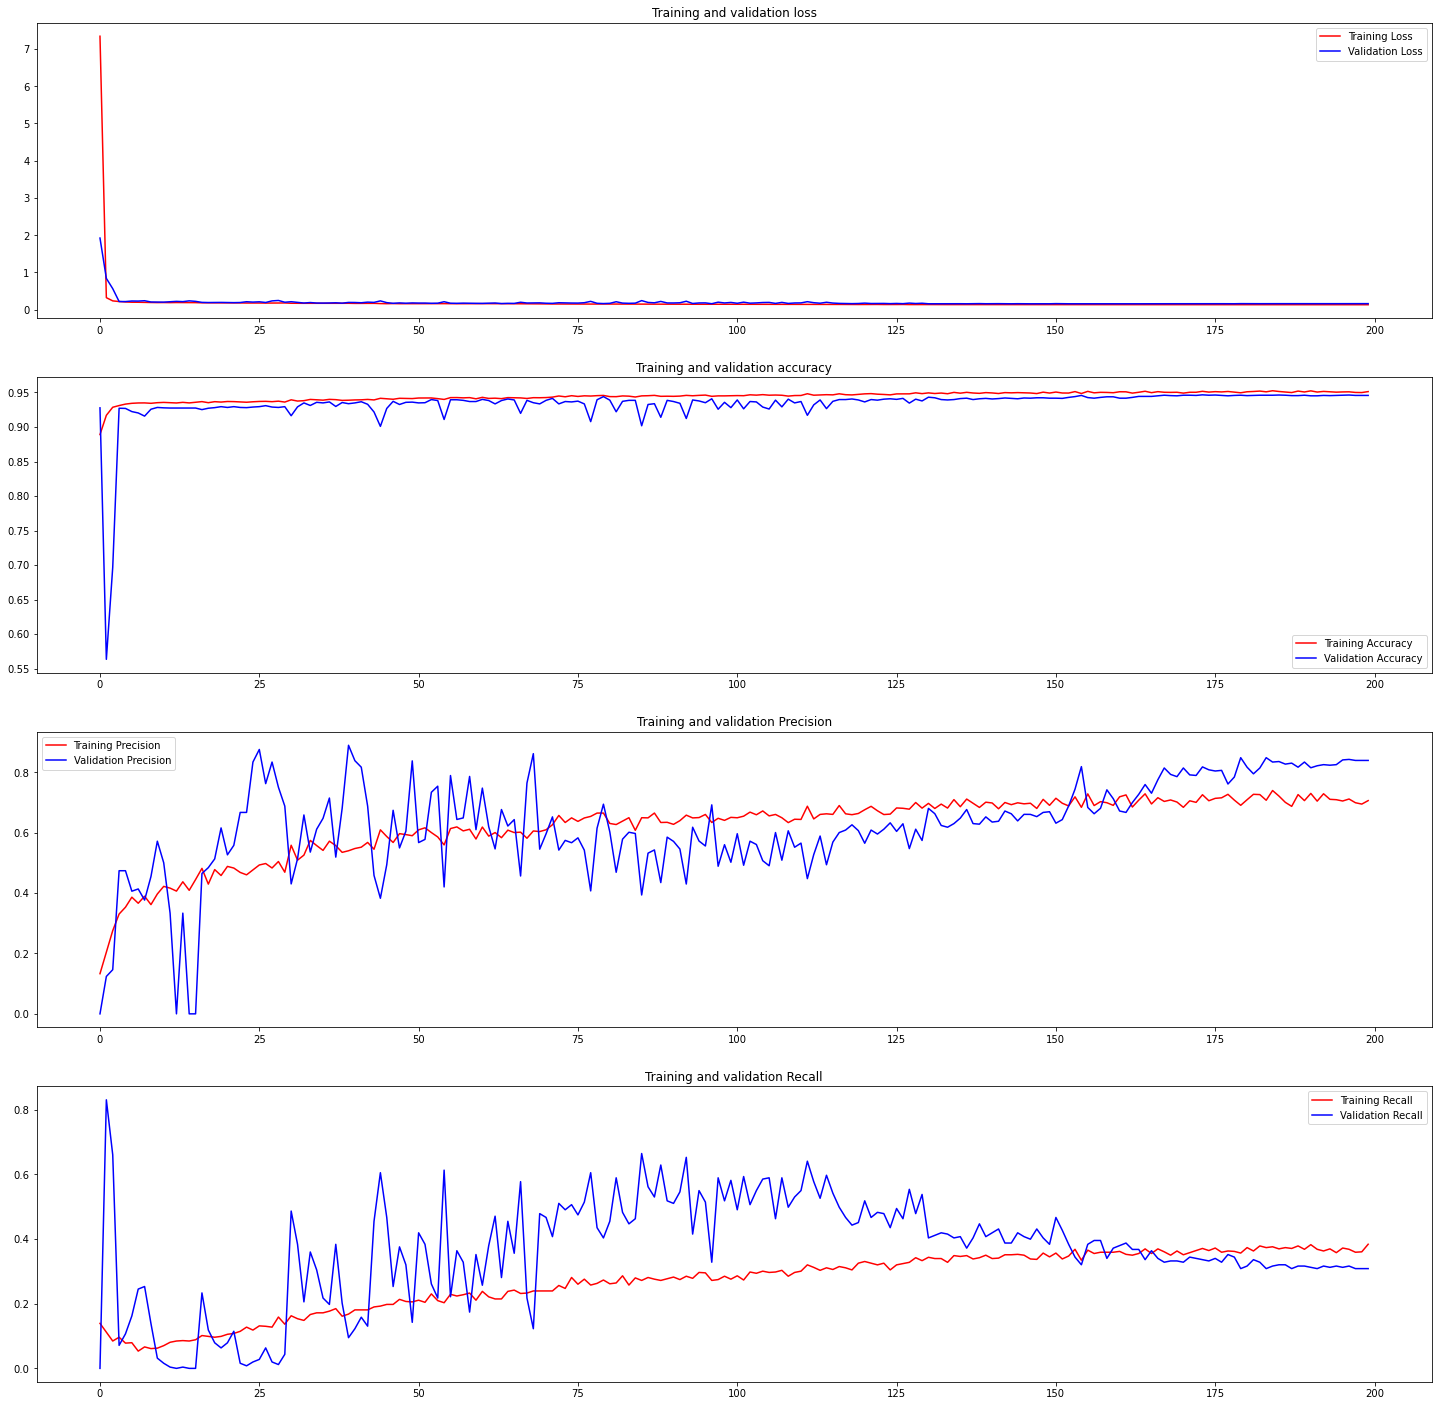

In [8]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
precision = hist.history['precision']
val_precision = hist.history['val_precision']
recall = hist.history['recall']
val_recall = hist.history['val_recall']

# Plot the graph manually
epochs = range(len(loss))

plt.figure(figsize=(25, 25))
plt.subplot(4, 1, 1)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(epochs, precision, 'r', label='Training Precision')
plt.plot(epochs, val_precision, 'b', label='Validation Precision')
plt.title('Training and validation Precision')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(epochs, recall, 'r', label = "Training Recall")
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

plt.show()

In [9]:
model.evaluate(validation_ds)

28/28 [==============================] - 1s 25ms/step - loss: 0.1626 - precision: 0.8387 - recall: 0.3083 - accuracy: 0.9457


[0.16256751120090485,
 0.8387096524238586,
 0.3083004057407379,
 0.9457452893257141]

In [15]:
test = tfds.as_numpy(test_ds)
y_pred = []
y_label = []

for i in test:
  flat_img = i[0]
  flat_label = i[1]
  pred = model.predict(flat_img)
  pred = np.round(pred)
  y_pred.extend(pred)
  y_label.extend(flat_label)

y_pred = np.array(y_pred)
y_label = np.array(y_label)

In [17]:
model.save('./CNN_Models/Distributed_model.h5')

In [16]:
from sklearn.metrics import classification_report

print(y_pred)
print(classification_report(y_label, y_pred))

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1648
           1       0.71      0.36      0.48       103

    accuracy                           0.95      1751
   macro avg       0.84      0.68      0.73      1751
weighted avg       0.95      0.95      0.95      1751

